# Language Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/language-detection](https://github.com/huseinzol05/malaya-speech/tree/master/example/language-detection).
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.utils.read.wav('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [3]:
# just going to take 30 seconds
y = y[:sr * 30]

In [4]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Supported languages

In [5]:
malaya_speech.language_detection.labels

['english',
 'indonesian',
 'malay',
 'mandarin',
 'manglish',
 'others',
 'not a language']

**Here we are not trying to tackle all possible languages, just towards hyperlocal languages in Malaysia**.

### List available deep model

In [6]:
malaya_speech.language_detection.available_model()

INFO:root:last accuracy during training session.


,Size (MB),Accuracy
vggvox-v1,70.8,0.90204
vggvox-v2,30.9,0.90204


### Load deep model

In [7]:
model = malaya_speech.language_detection.deep_model(model = 'vggvox-v2')

### How to classify languages in an audio sample

So we are going to use VAD to help us. Instead we are going to classify as a whole sample, we chunk it into multiple small samples and classify it.

In [8]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 1.34 ms, sys: 59 µs, total: 1.4 ms
Wall time: 1.41 ms


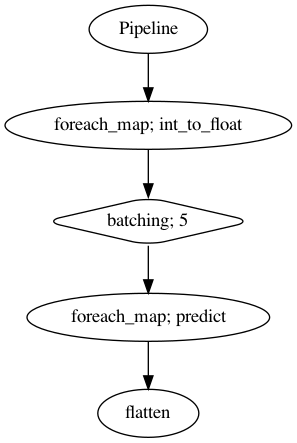

In [10]:
p = Pipeline()
pipeline = (
    p.foreach_map(malaya_speech.utils.astype.int_to_float)
    .batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [11]:
%%time

result = p.emit(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 32 s, sys: 5.77 s, total: 37.7 s
Wall time: 7.85 s


dict_keys(['int_to_float', 'batching', 'predict', 'flatten'])

In [12]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

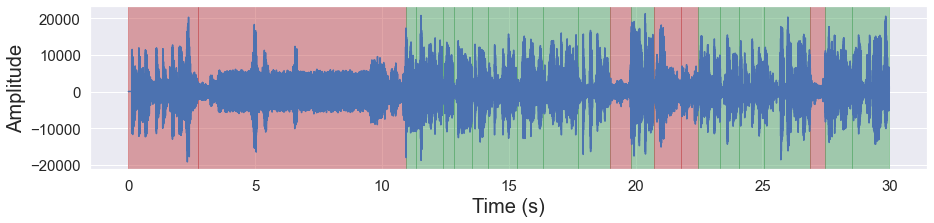

In [19]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

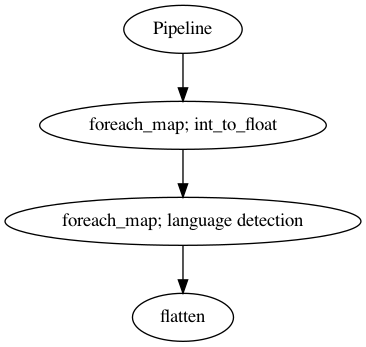

In [14]:
p = Pipeline()
pipeline = (
    p.foreach_map(malaya_speech.utils.astype.int_to_float)
    .foreach_map(model)
    .flatten()
)
p.visualize()

In [15]:
%%time

samples_vad = [g[0] for g in grouped_vad]
result = p.emit(samples_vad)
result.keys()

CPU times: user 4.79 s, sys: 901 ms, total: 5.69 s
Wall time: 1.4 s


dict_keys(['int_to_float', 'language-detection', 'flatten'])

In [16]:
samples_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(samples_vad)]
samples_vad

[(<malaya_speech.model.frame.FRAME at 0x142c20e10>, 'not a language'),
 (<malaya_speech.model.frame.FRAME at 0x142573250>, 'not a language'),
 (<malaya_speech.model.frame.FRAME at 0x142573910>, 'manglish'),
 (<malaya_speech.model.frame.FRAME at 0x142573290>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x142573190>, 'english'),
 (<malaya_speech.model.frame.FRAME at 0x14a184490>, 'english'),
 (<malaya_speech.model.frame.FRAME at 0x14a184410>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x14a1844d0>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x14a184550>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x14a184510>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x14a1843d0>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x1425734d0>, 'not a language'),
 (<malaya_speech.model.frame.FRAME at 0x142573050>, 'malay'),
 (<malaya_speech.model.frame.FRAME at 0x14251ef90>, 'others'),
 (<malaya_speech.model.frame.FRAME at 0x14251ed10>, 'english'),
 (<malaya_speech.model.frame.FRAM

In [17]:
import matplotlib.pyplot as plt

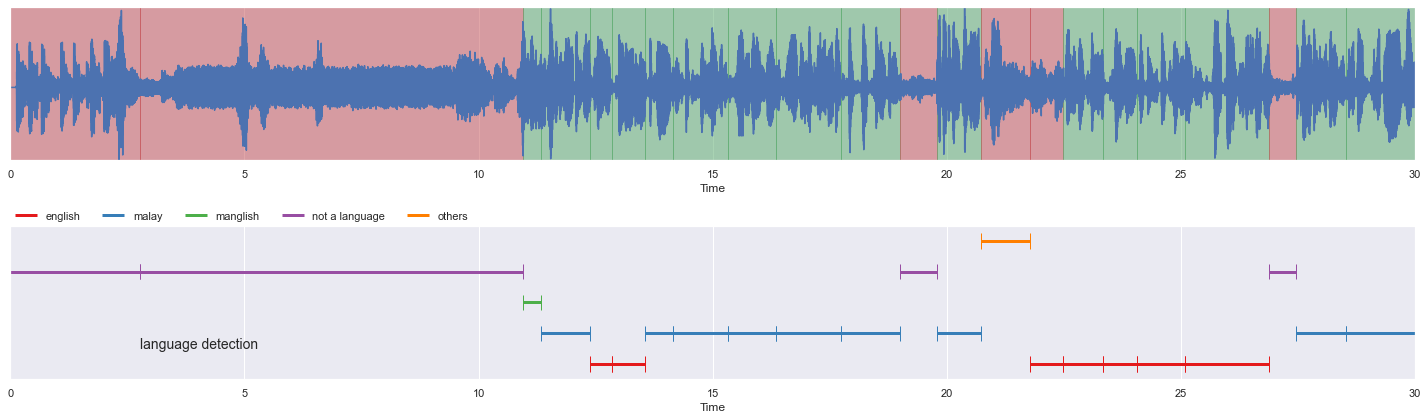

In [18]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(samples_vad, 'language detection', ax = ax[1])
fig.tight_layout()
plt.show()